# Variational Quantum Eigensolver using classical optimisers
### Estimation of ground state energy, Hamiltonian $H_{3}= X_{0}Z_{1}X_{2} + X_{0}Z_{2} + X_{1}Z_{2}$

In [1]:
#Import libraries
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from math import pi
import matplotlib.pylab as plt
from itertools import product
from qiskit.quantum_info import Operator
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_bo import *

from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from scipy.linalg import eigh



In this cell, we define the quantum circuit designed to estimate the ground state energy. You can also modify the Hamiltonian and the initial state directly within this cell, allowing for flexibility in the setup. <br />


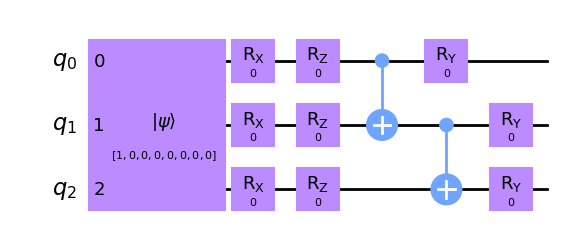

In [2]:
#Define the circuit
def create_circuit_VQE3(thetas, initial_state):
    circ = QuantumCircuit(3)
    # Define parameters for rotation gates
    circ.initialize(initial_state, [0,1,2])
    
    # Apply parameterized rotation gates
    circ.rx(thetas[0,0], 0)
    circ.rx(thetas[0,1], 1)
    circ.rx(thetas[0,2], 2)

    circ.rz(thetas[0,3], 0)
    circ.rz(thetas[0,4], 1)
    circ.rz(thetas[0,5], 2)
    
    # Apply entangling gates
    circ.cx(0, 1)
    circ.cx(1, 2)
    
    circ.ry(thetas[0,6], 0)
    circ.ry(thetas[0,7], 1)
    circ.ry(thetas[0,8], 2)

    return circ

n_thetas = 9 #Number of parameters
num_qubits = 3

thetas = np.random.rand(n_thetas)
initial_state = np.zeros(2**num_qubits)
initial_state[0] = 1


H = (SparsePauliOp.from_list([
    ('XZX', 1.0),
    ('XIZ', 1.0),
    ('IXZ', 1.0)
]))




circ_visualization = create_circuit_VQE3(np.zeros(n_thetas)[np.newaxis,:],initial_state)
circ_visualization.draw('mpl')

We define the function to optimise

In [3]:
def target_function(thetas):
    circuit = create_circuit_VQE3
    new_exp_values, new_eigenvalue = get_expectation_values_hamiltonian(circuit, np.array(thetas)[np.newaxis,:], initial_state, H)
    return -new_eigenvalue  

# SPSA

In [4]:
n_run = 10
n_total_timesteps = 200 

params = {'n_runs': n_run,
          'n_total_timesteps':n_total_timesteps,
         
         }

metrics = {
    'best_eigenvalue_runs': np.zeros(n_run),
    'history_best_eigenvalue_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas)),
    }

for iter_run in range(n_run):

    best_eigenvalue, eigenvalue_history = float('inf'), []
    best_thetas, thetas_history = np.zeros(n_thetas), []
    X_train, y_train = [], []
    
    def wrapper_objective_function(params):
        global best_eigenvalue
        global best_thetas

        y = target_function(params)
        X_train.append(params[0])
        y_train.append(y)

        if y<best_eigenvalue:
            best_eigenvalue = y
            best_thetas = params
        eigenvalue_history.append(best_eigenvalue)
        thetas_history.append(best_thetas)
        return y

    # Initialise the SPSA optimizer
    optimizer = SPSA(maxiter=n_total_timesteps//2)

    # Initial parameters for the circuit
    initial_params = np.random.rand(n_thetas)
    results = optimizer.minimize(
            wrapper_objective_function,
            x0=initial_params )

    #We only keep results until n_total_timesteps
    metrics['history_best_eigenvalue_runs'][iter_run,:] = np.array(eigenvalue_history)[:n_total_timesteps]
    metrics['best_eigenvalue_runs'][iter_run] = np.array(eigenvalue_history)[n_total_timesteps]
    best_thetas = np.array(thetas_history)[n_total_timesteps]
    metrics['best_thetas_runs'][iter_run,:] = best_thetas



y_train = np.array(y_train)[:n_total_timesteps]
X_train = np.array(X_train)[:n_total_timesteps]

In [5]:
eigenvalues, eigenvectors = eigh(H.to_matrix())
ground_state_energy = np.min(eigenvalues)
ground_state = eigenvectors[:, np.argmin(eigenvalues)]
print(f"Ground state energy: {ground_state_energy}")

Ground state energy: -2.4142135623730954


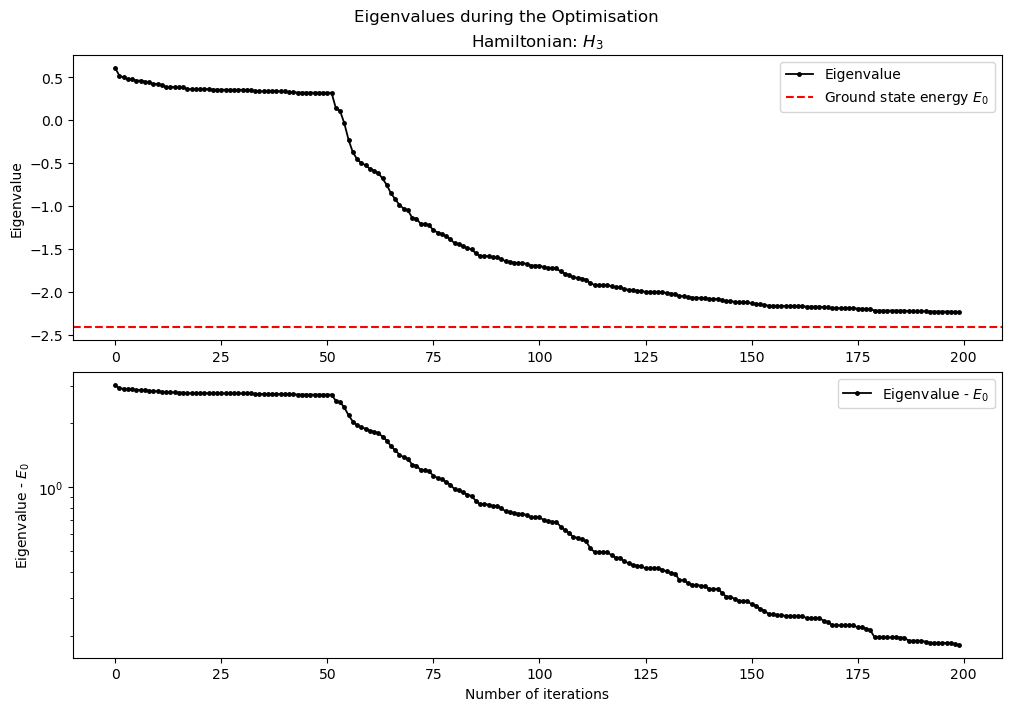

In [6]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during the Optimisation')
ax[0].set_title(r'Hamiltonian: $H_{3}$')
ax[0].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')
ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')


plt.legend()
plt.show()

In [7]:
data_plot = {   'history_best_eigenvalue_runs':metrics['history_best_eigenvalue_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_eigenvalue_runs':metrics['best_eigenvalue_runs'],
                'real_ground_state_energy':ground_state_energy,

            } 
if True:
    with open("../results/vqe/results_hamiltonian_"+ str(num_qubits)+"qubits_spsa.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

In [8]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_eigenvalue_runs': -np.mean(np.abs(metrics['best_eigenvalue_runs'])),
    'std_eigenvalue_runs': np.std(np.abs(metrics['best_eigenvalue_runs'])),
        }

params['size_final_dataset'] =  y_train.shape[0]

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VQE_H3")

with mlflow.start_run(run_name='VQE_H3_SPSA'):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    

2024/09/22 13:19:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run VQE_H3_SPSA at: http://127.0.0.1:8080/#/experiments/442175021139790135/runs/a03a45b96a3643afbf318990cccc8e91.
2024/09/22 13:19:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/442175021139790135.


# L_BFGS_B

In [9]:
n_run = 10
n_total_timesteps = 200 

params = {'n_runs': n_run,
          'n_total_timesteps':n_total_timesteps,
         
         }

metrics = {
    'best_eigenvalue_runs': np.zeros(n_run),
    'history_best_eigenvalue_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas)),
    }

for iter_run in range(n_run):

    best_eigenvalue, eigenvalue_history = float('inf'), []
    best_thetas, thetas_history = np.zeros(n_thetas), []
    X_train, y_train = [], []
    
    def wrapper_objective_function(params):
        global best_eigenvalue
        global best_thetas

        y = target_function(params)
        X_train.append(params[0])
        y_train.append(y)

        if y<best_eigenvalue:
            best_eigenvalue = y
            best_thetas = params
        eigenvalue_history.append(best_eigenvalue)
        thetas_history.append(best_thetas)
        return y

    # Initialise the SPSA optimizer
    optimizer = L_BFGS_B(maxiter=n_total_timesteps//2)

    # Initial parameters for the circuit
    initial_params = np.random.rand(n_thetas)
    results = optimizer.minimize(
            wrapper_objective_function,
            x0=initial_params )

    #We only keep results until n_total_timesteps
    #LBFGS sometimes stop before n_total_timesteps
    if np.array(eigenvalue_history).shape[0]<=n_total_timesteps:
            fill_nan = np.nan*np.zeros(n_total_timesteps - np.array(eigenvalue_history).shape[0])
            metrics['history_best_eigenvalue_runs'][iter_run,:] = np.hstack((eigenvalue_history,fill_nan))
            metrics['best_eigenvalue_runs'][iter_run] = eigenvalue_history[-1]
            best_thetas = thetas_history[-1]
            metrics['best_thetas_runs'][iter_run,:] = best_thetas


    else:

        metrics['history_best_eigenvalue_runs'][iter_run,:] = np.array(eigenvalue_history)[:n_total_timesteps]
        metrics['best_eigenvalue_runs'][iter_run] = np.array(eigenvalue_history)[n_total_timesteps]
        best_thetas = np.array(thetas_history)[n_total_timesteps]
        metrics['best_thetas_runs'][iter_run,:] = best_thetas



y_train = np.array(y_train)[:n_total_timesteps]
X_train = np.array(X_train)[:n_total_timesteps]

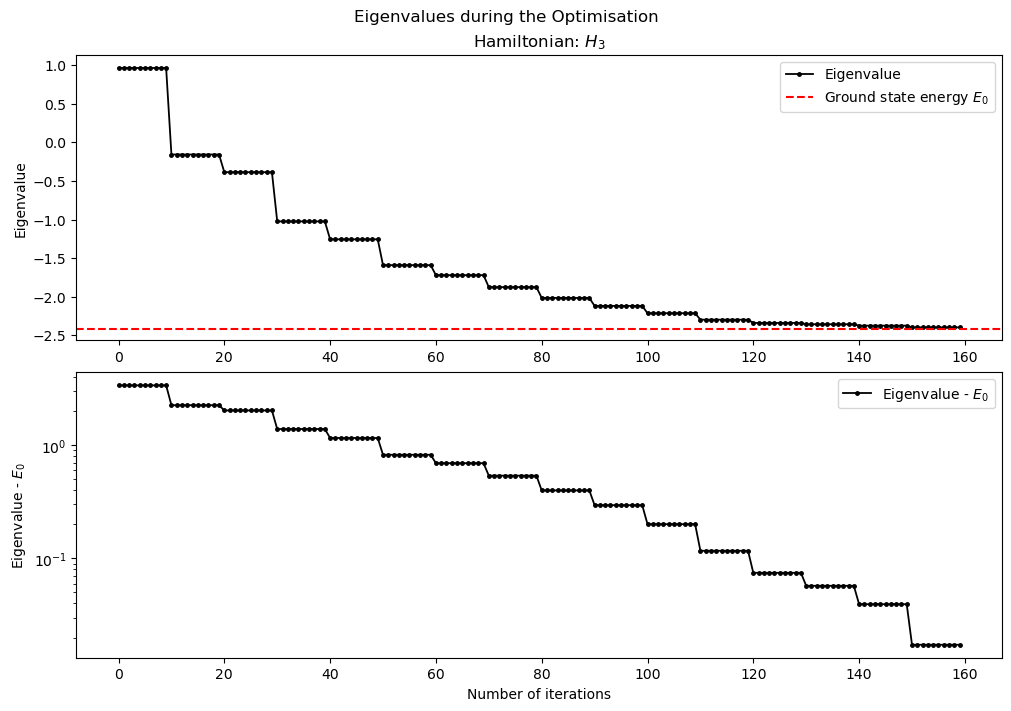

In [10]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during the Optimisation')
ax[0].set_title(r'Hamiltonian: $H_{3}$')
ax[0].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')
ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')


plt.legend()
plt.show()

In [11]:
data_plot = {   'history_best_eigenvalue_runs':metrics['history_best_eigenvalue_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_eigenvalue_runs':metrics['best_eigenvalue_runs'],
                'real_ground_state_energy':ground_state_energy,

            } 
if True:
    with open("../results/vqe/results_hamiltonian_"+ str(num_qubits)+"qubits_lbfgsb.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

In [12]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_eigenvalue_runs': -np.mean(np.abs(metrics['best_eigenvalue_runs'])),
    'std_eigenvalue_runs': np.std(np.abs(metrics['best_eigenvalue_runs'])),
        }

params['size_final_dataset'] =  y_train.shape[0]

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VQE_H3")

with mlflow.start_run(run_name='VQE_H3_LBFGSB'):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    

2024/09/22 13:19:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run VQE_H3_LBFGSB at: http://127.0.0.1:8080/#/experiments/442175021139790135/runs/f3127921149b42fc8bfccccb03e61451.
2024/09/22 13:19:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/442175021139790135.
